# Porto Seguro's Safe Driver Prediction

### In this competition, you will predict the probability that an auto insurance policy holder files a claim.

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.

## 1. Preprocessing

In [1]:
import pandas as pd
import numpy as np
import json
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [2]:
from google.colab import files
files.upload()  # Select kaggle.json from your computer

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle competitions download -c porto-seguro-safe-driver-prediction
!unzip porto-seguro-safe-driver-prediction.zip -d dataset

100% 76.5M/76.5M [00:04<00:00, 31.1MB/s]
100% 76.5M/76.5M [00:04<00:00, 19.3MB/s]
Archive:  porto-seguro-safe-driver-prediction.zip
  inflating: dataset/sample_submission.csv  
  inflating: dataset/test.csv        
  inflating: dataset/train.csv       


In [4]:

train_data = pd.read_csv("dataset/train.csv")
test_data = pd.read_csv("dataset/test.csv")

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [6]:
train_data.shape

(595212, 59)

In [7]:
train_data.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [8]:
#missing observations are indicated by -1
missing_data = train_data.eq(-1).sum()
missing_data = missing_data[missing_data > 0]
missing_percent = missing_data/len(train_data)
missing_percent

#drop values with a missing percent larger than 0.4
cols_to_drop = missing_percent[missing_percent > 0.4].index
train_data.drop(cols_to_drop, axis=1, inplace=True)
test_data.drop(cols_to_drop, axis=1, inplace=True)



In [9]:
#separate different variable types
cat_cols = train_data.filter(like="_cat")
bin_cols = train_data.filter(like ='bin')
num_cols = train_data.drop(columns = cat_cols.columns).drop(columns = bin_cols.columns).drop(columns = ['id','target'])
target = train_data['target']

## Exploratory Data Analysis

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

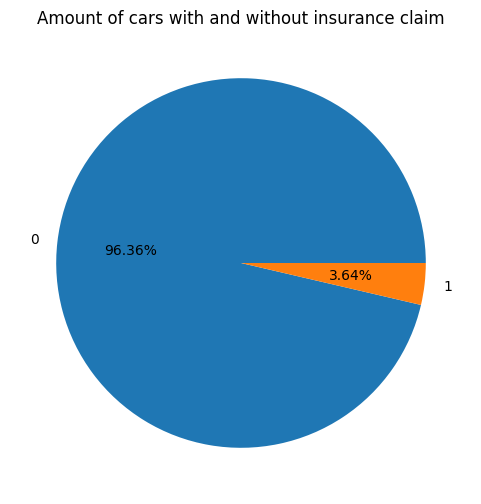

In [11]:
counts = train_data['target'].value_counts()
vals = train_data['target'].value_counts().values

fig, ax = plt.subplots(figsize=(6,6))
ax.pie(vals, labels=[0,1], autopct='%1.2f%%')
ax.set_title('Amount of cars with and without insurance claim')
plt.show()

In [12]:
num_cols.describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,...,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,0.610991,0.439184,0.551102,2.346072,0.379945,0.813265,...,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.287643,0.404264,0.793506,0.832548,0.058327,0.224588,...,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.250619,...,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,0.400000,0.200000,0.525000,2.000000,0.316228,0.670867,...,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,0.700000,0.300000,0.720677,3.000000,0.374166,0.765811,...,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,0.900000,0.600000,1.000000,3.000000,0.400000,0.906190,...,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,0.900000,1.800000,4.037945,3.000000,1.264911,3.720626,...,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


Feature names are not explanatory and I cannot make a difference whether a feature with a 1-9 scale is on an ordinal or a ratio scale.

Based on the description of the task:  "In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder."

Based on this _cat features are non-binary categorical features. The assignment explicitly mentioned that other variables (without _cat, or_bin label) are either ordinal or continous so I will assume that _cat is only for non-binary nominal features (it could also mean ordinal otherwise).



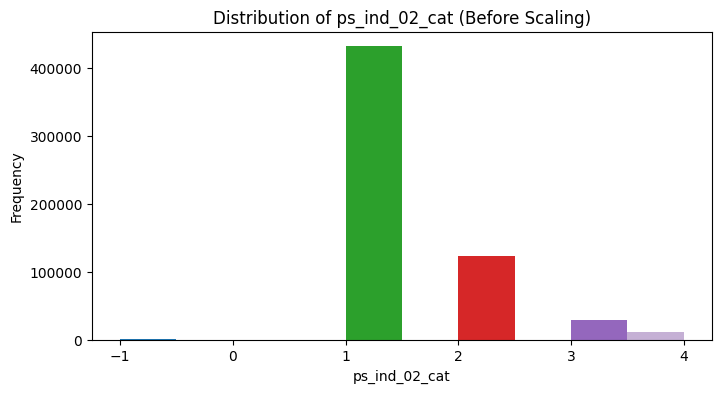

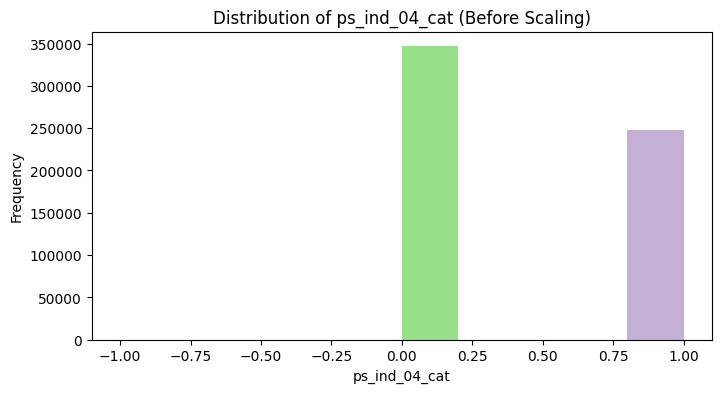

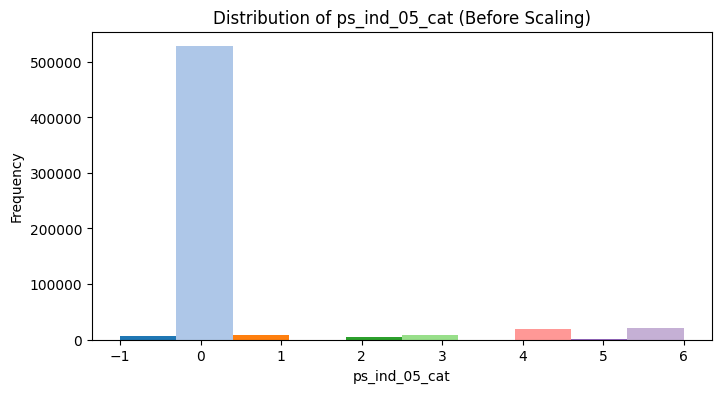

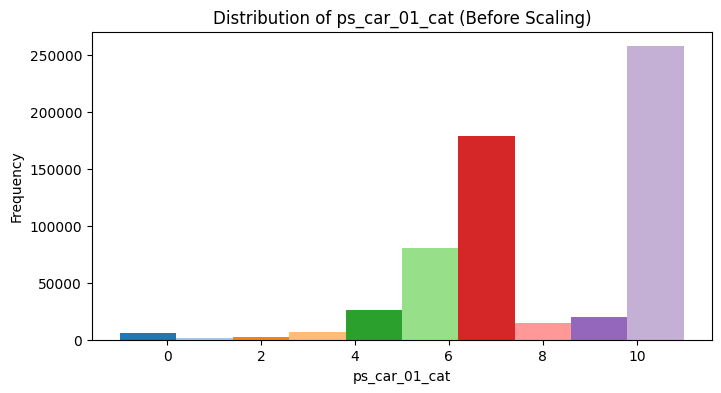

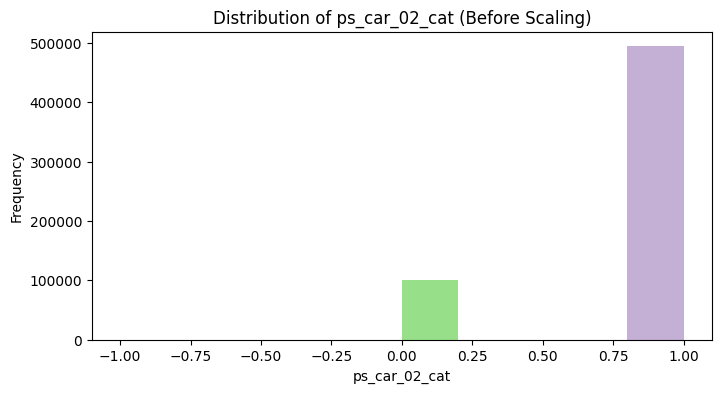

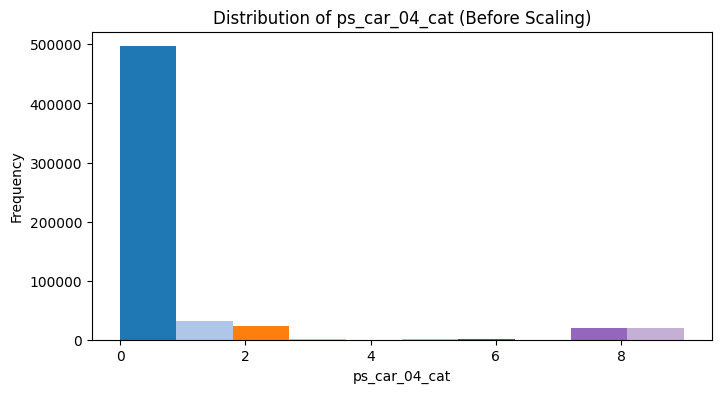

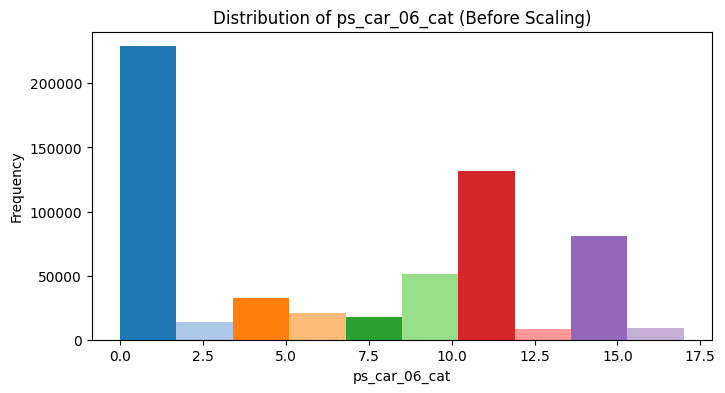

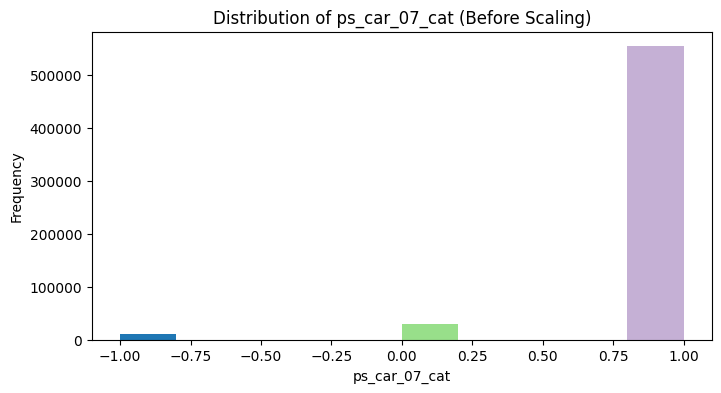

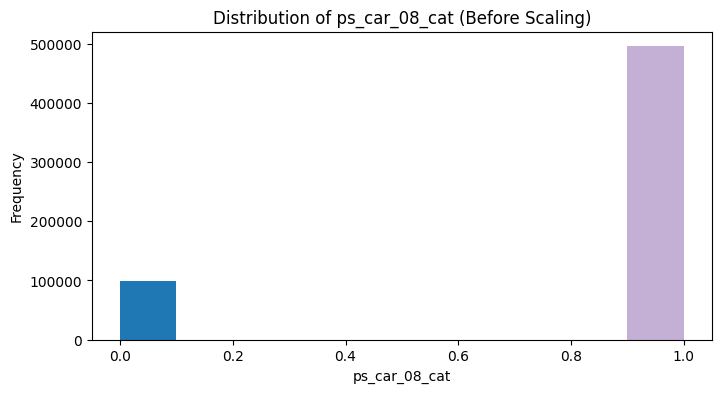

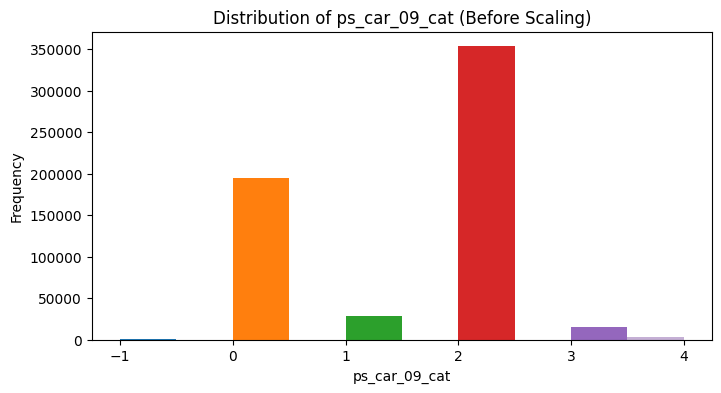

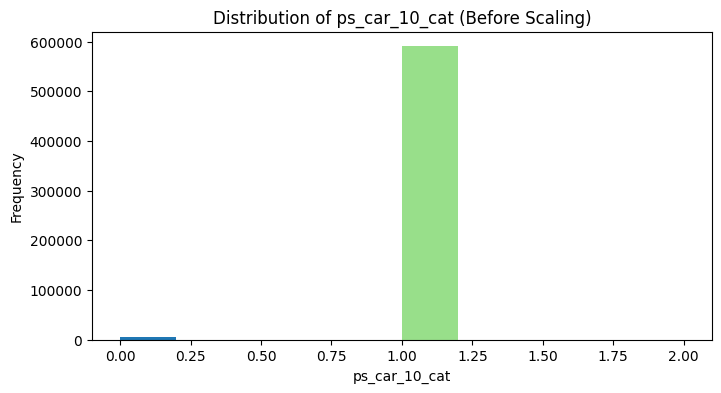

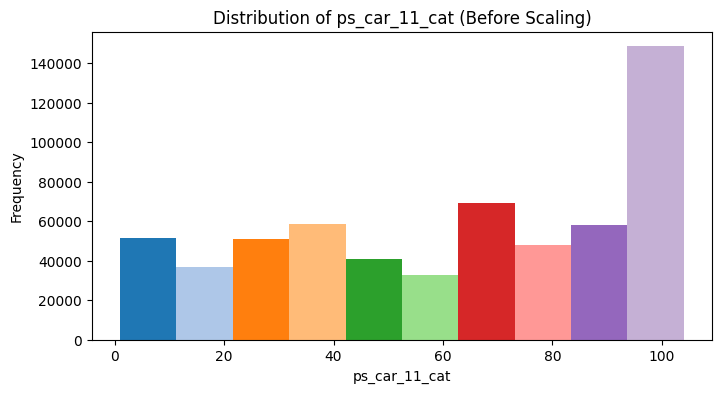

In [13]:
def plot_distributions(df,bin_num):

    colors = sns.color_palette("tab20", bin_num)  # Get a color palette with enough colors

    for col in df:
        plt.figure(figsize=(8, 4))  # Create a new figure for each plot
        # Create the histogram and use the color palette
        bins = np.linspace(df[col].min(), df[col].max(), bin_num + 1)  # Define the bins
        hist, edges = np.histogram(df[col], bins=bins)

        # Plot each bin with a different color
        for i in range(bin_num):
            plt.bar(edges[i], hist[i], width=edges[i+1] - edges[i], color=colors[i], align="edge")

        plt.title(f'Distribution of {col} (Before Scaling)')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()  # Display the plot one by one

plot_distributions(cat_cols,10)

They are not showing any specific distribution or useful information. Outliers could be further analyzed.

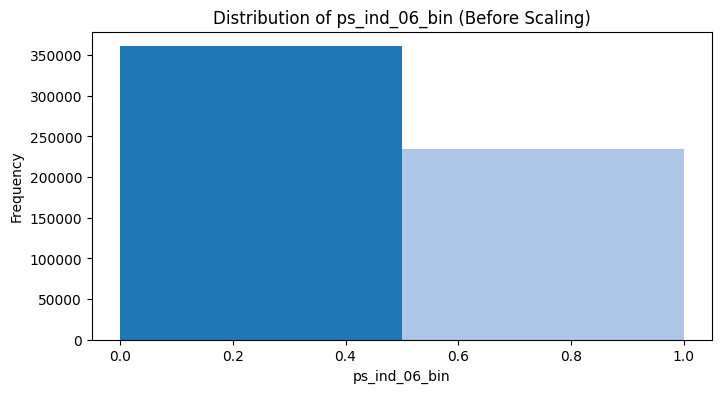

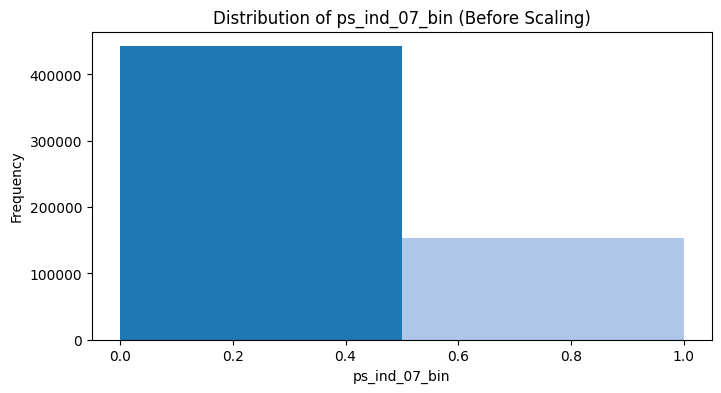

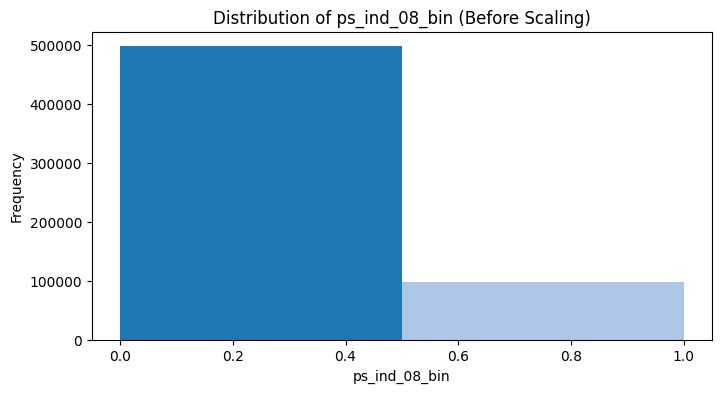

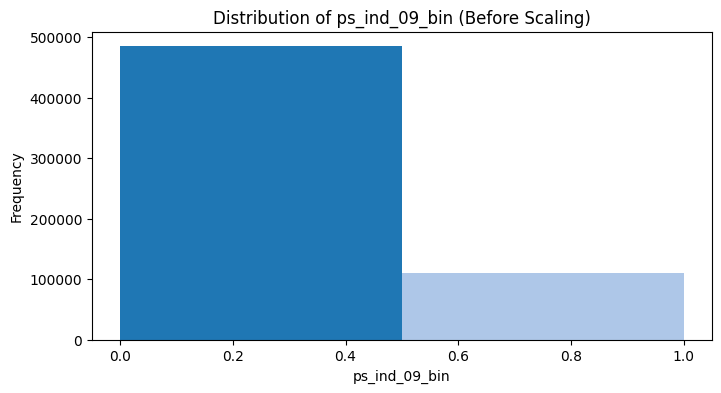

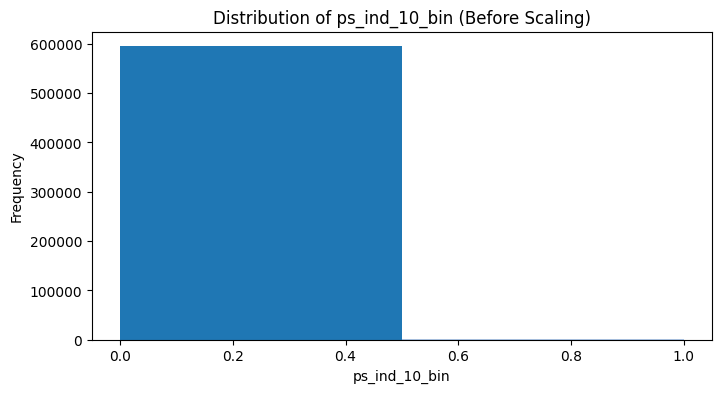

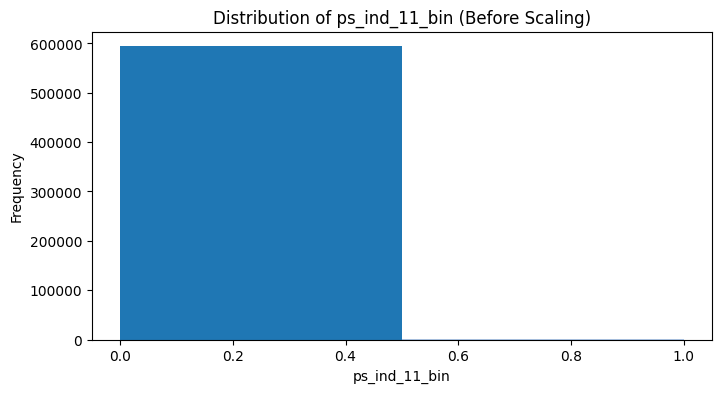

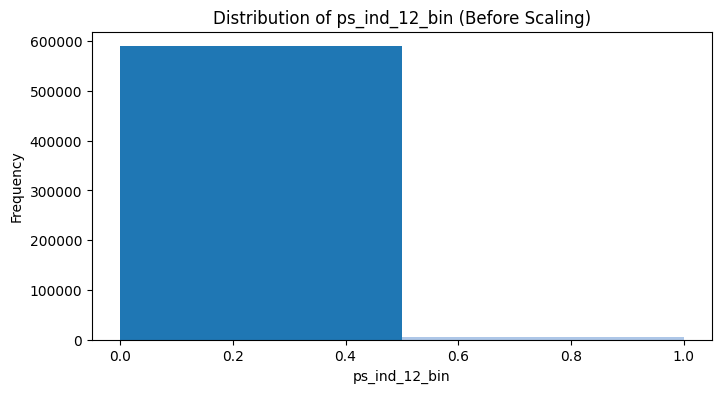

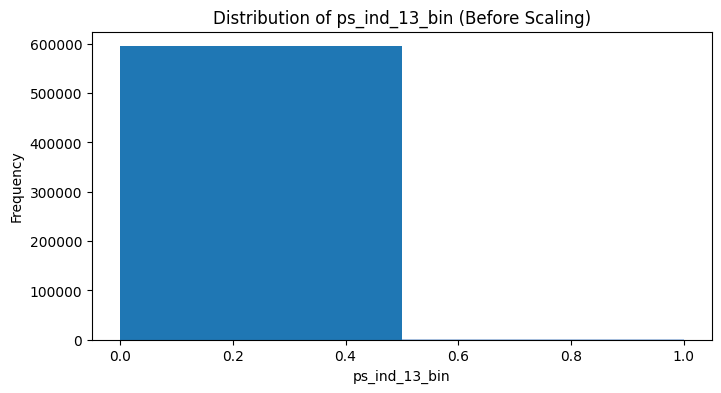

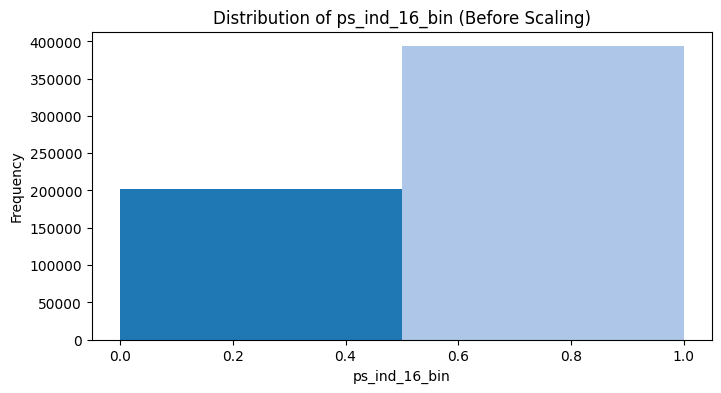

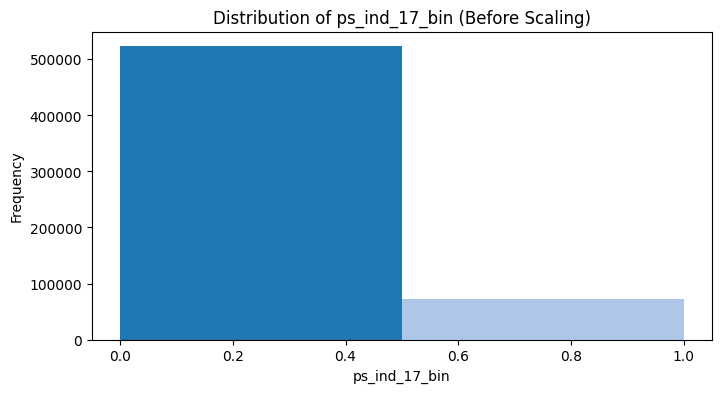

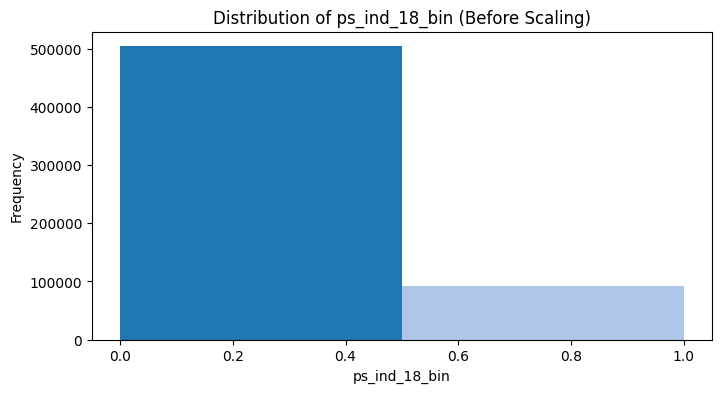

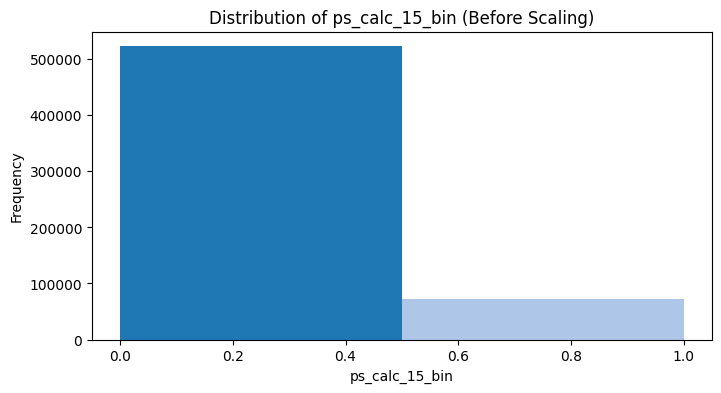

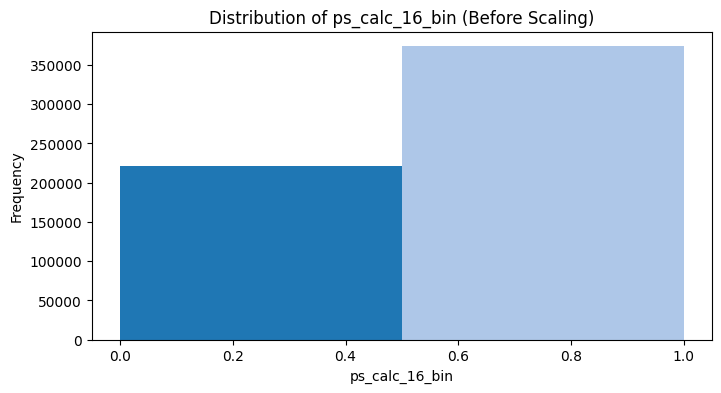

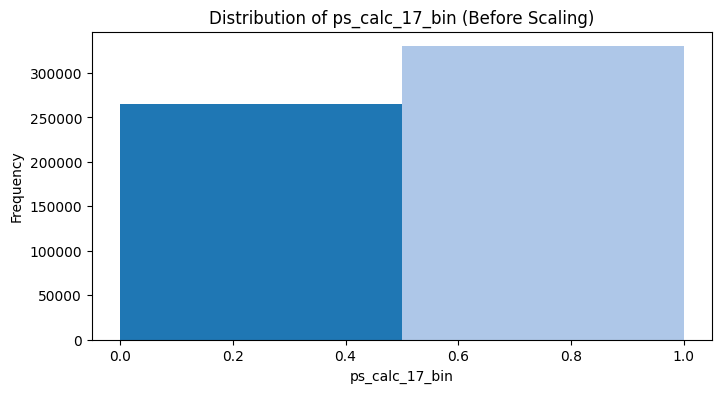

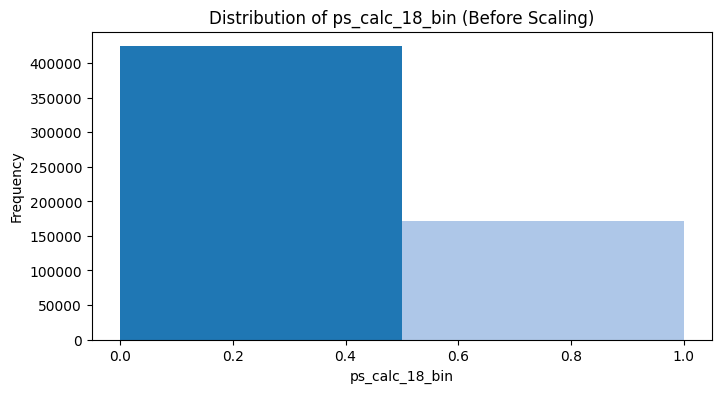

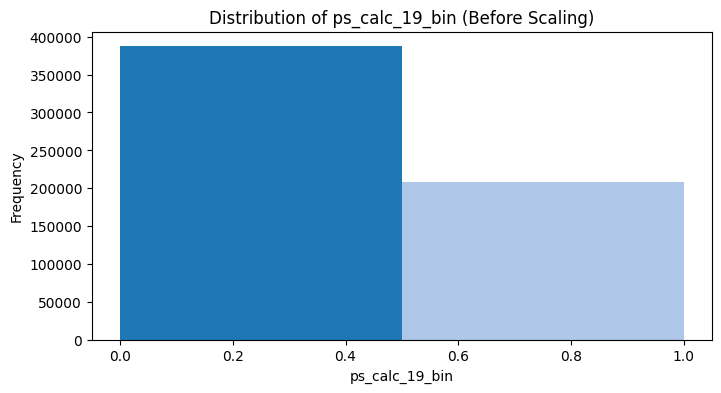

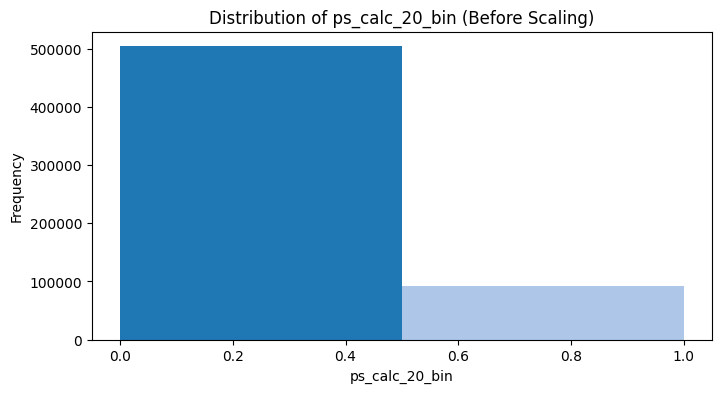

In [14]:
plot_distributions(bin_cols,2)

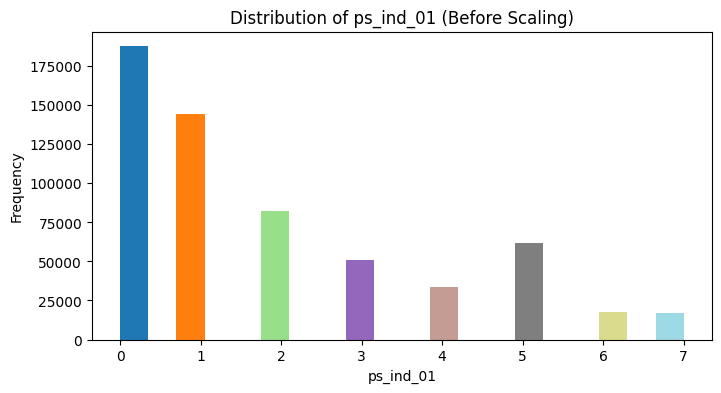

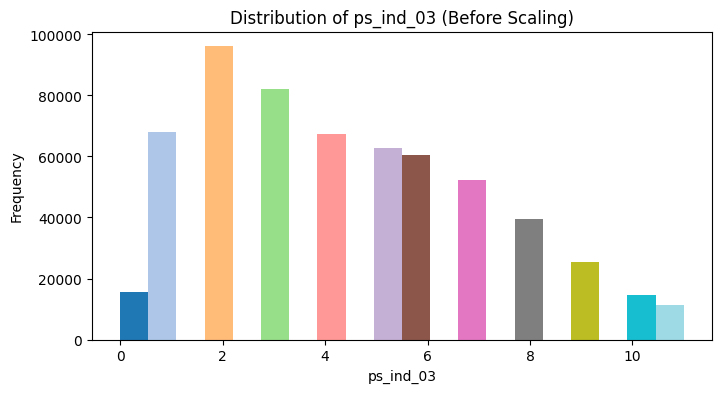

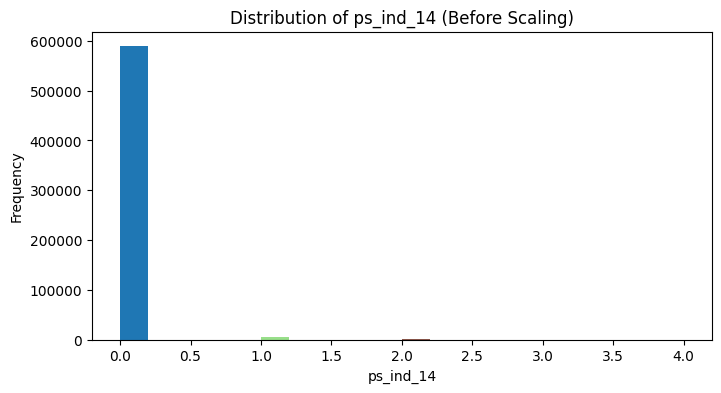

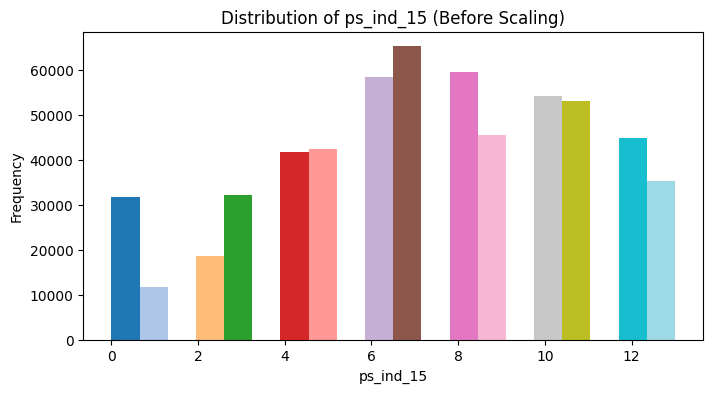

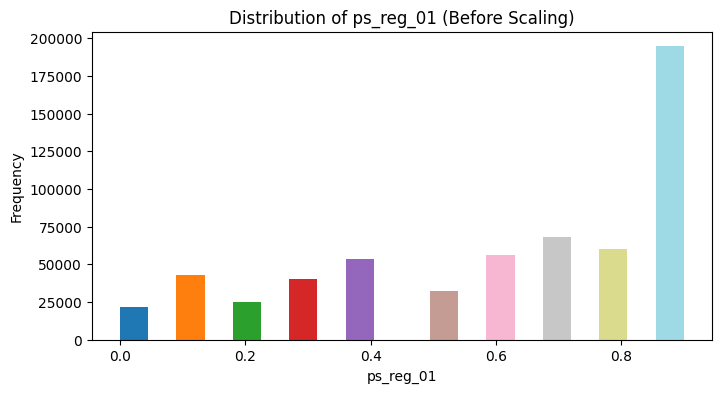

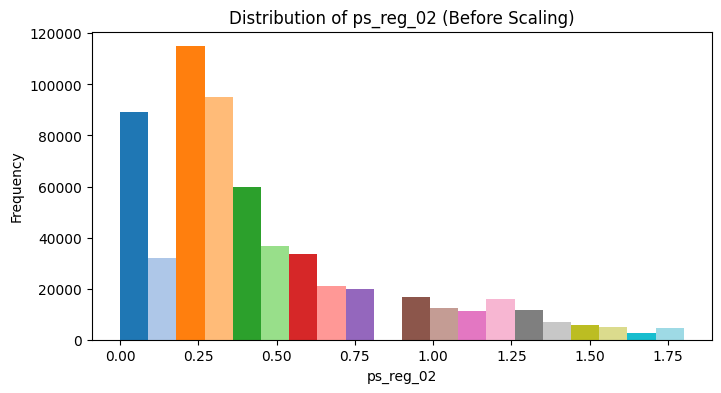

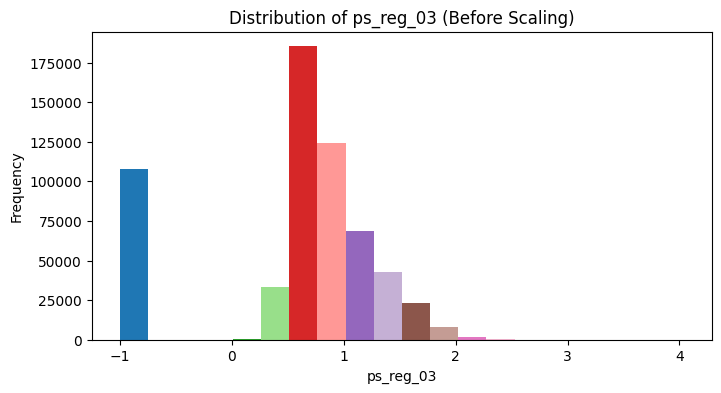

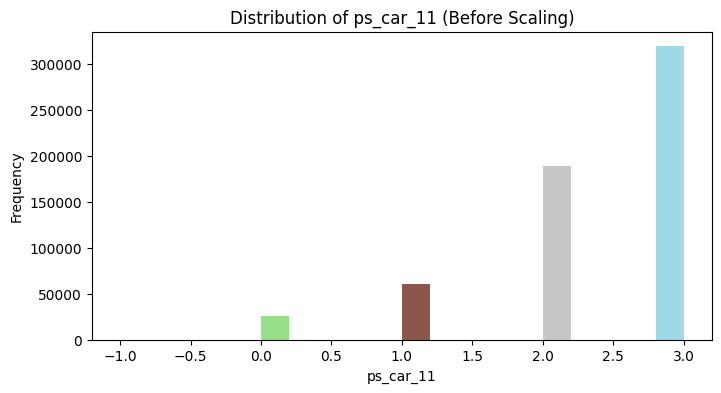

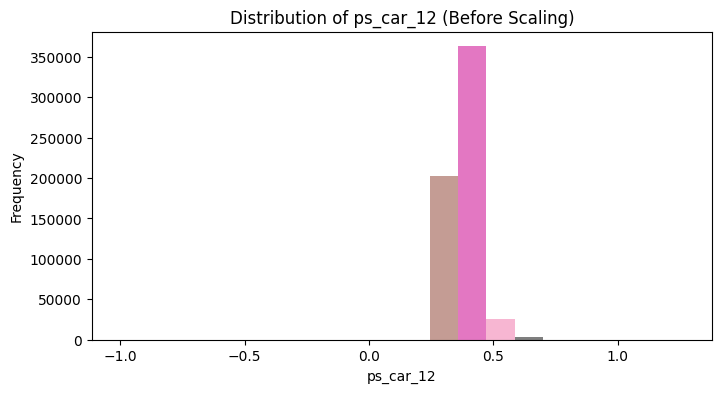

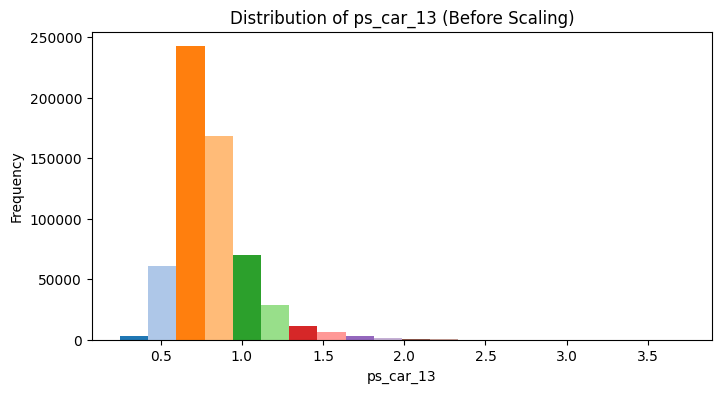

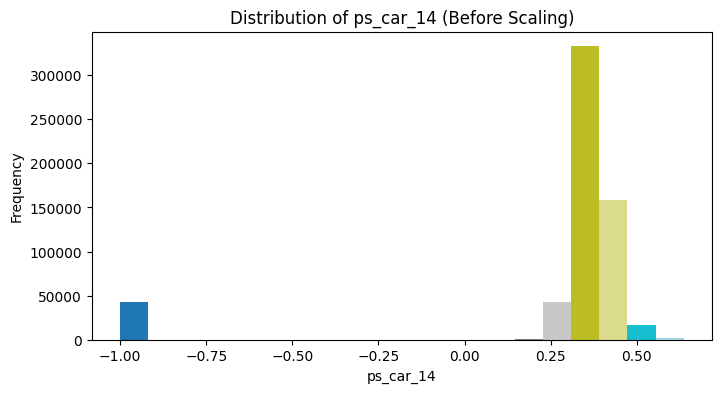

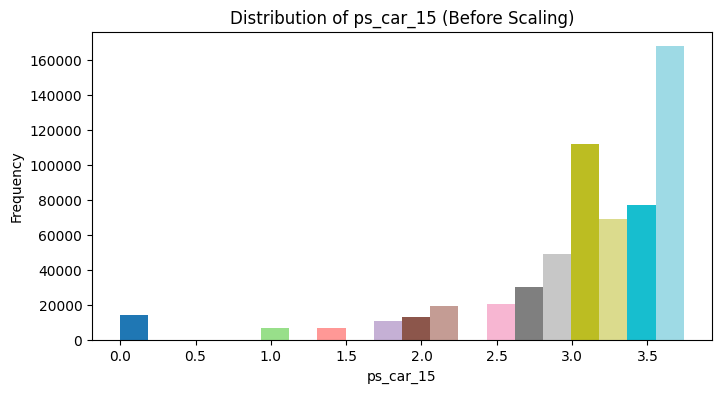

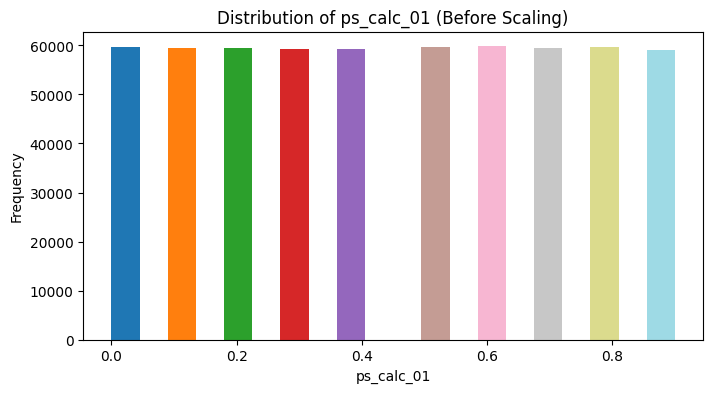

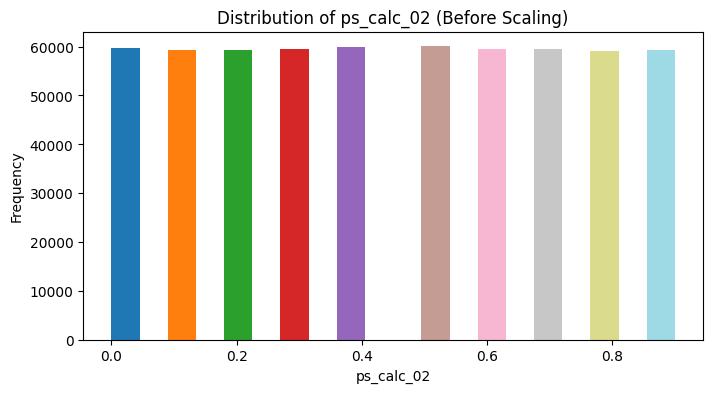

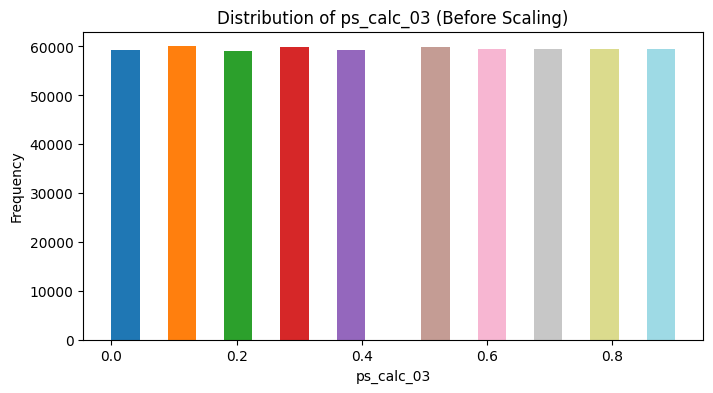

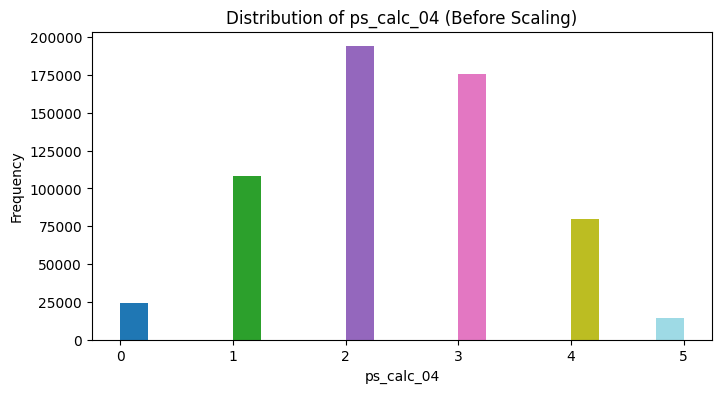

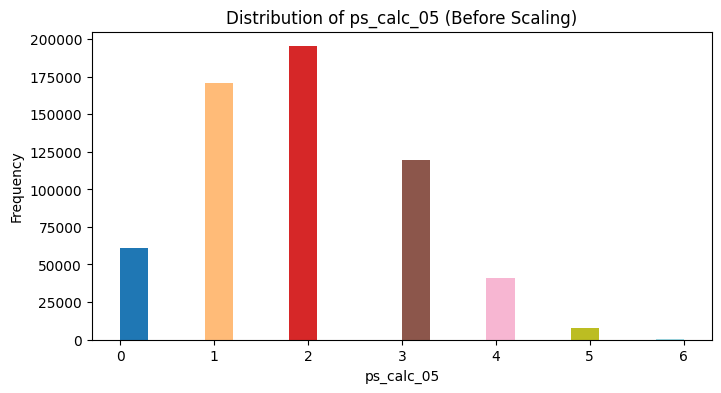

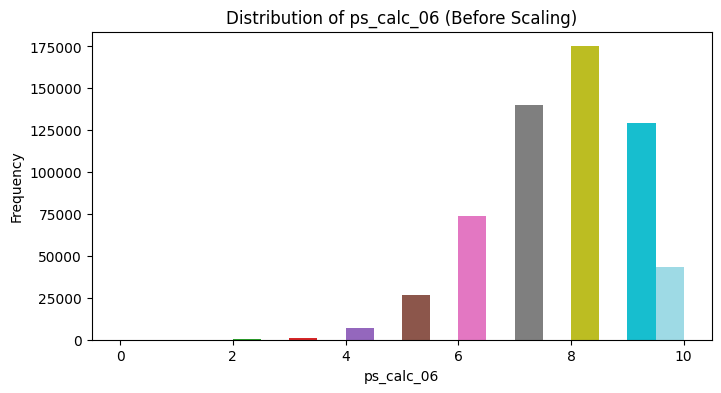

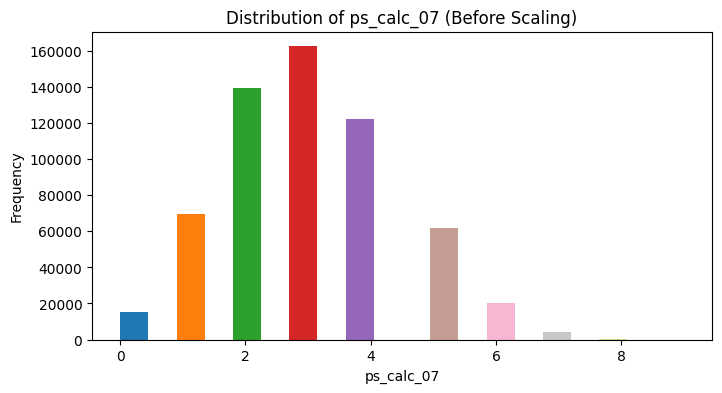

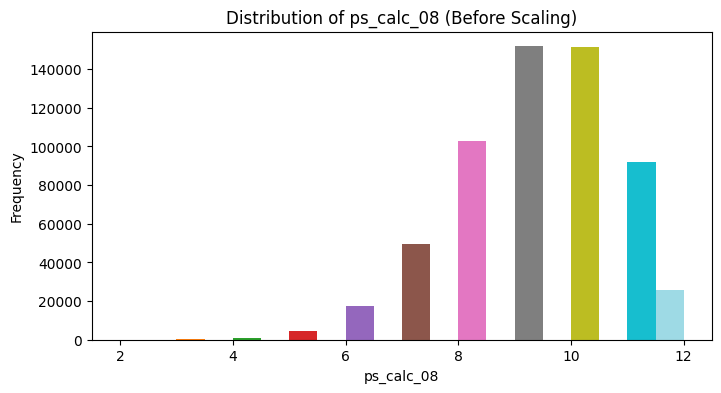

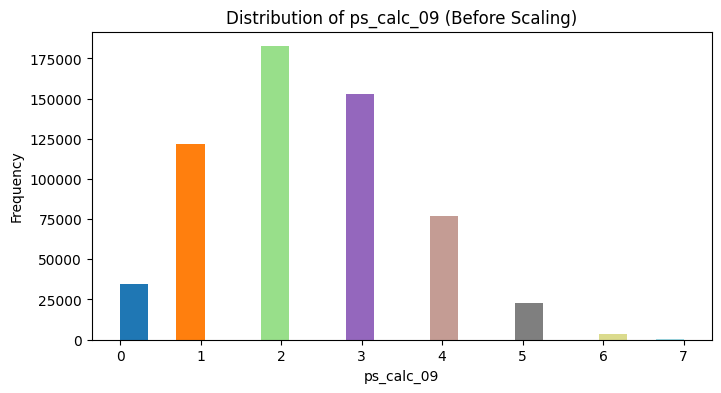

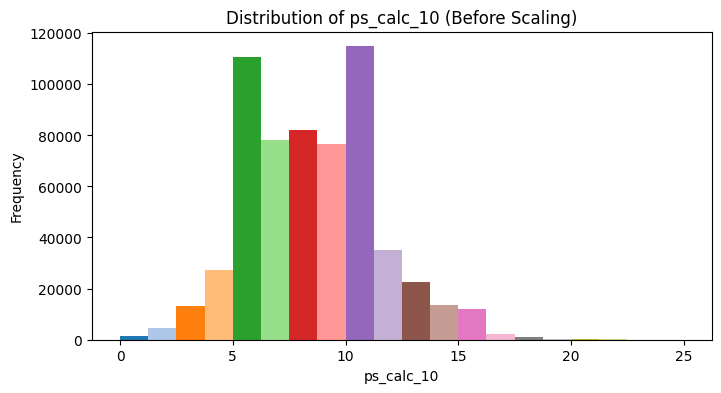

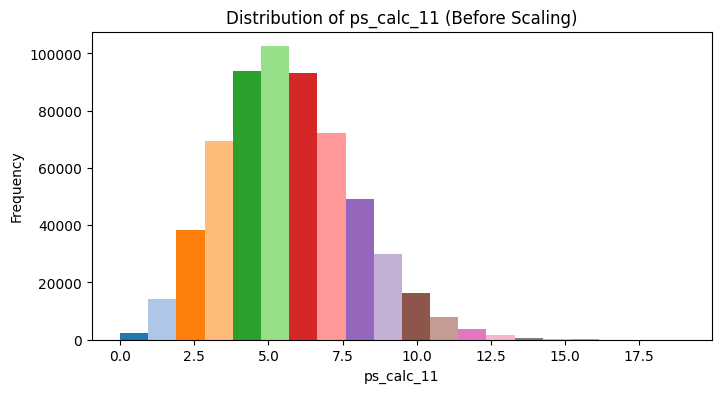

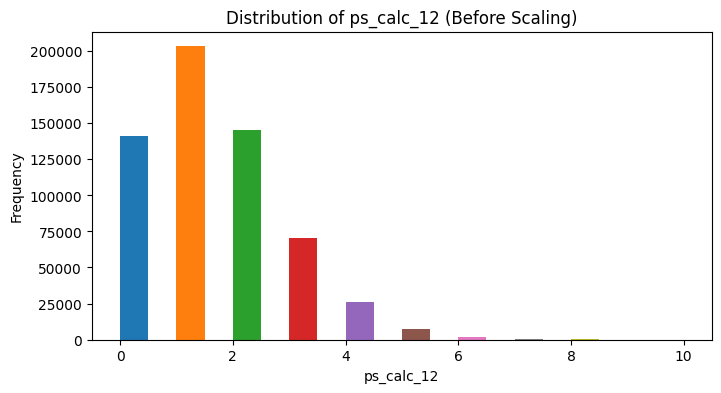

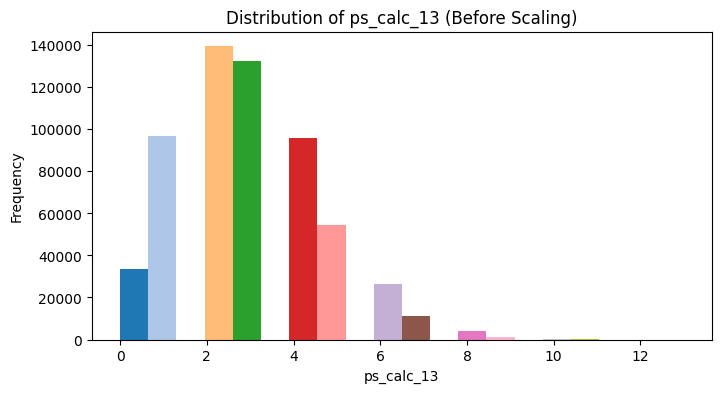

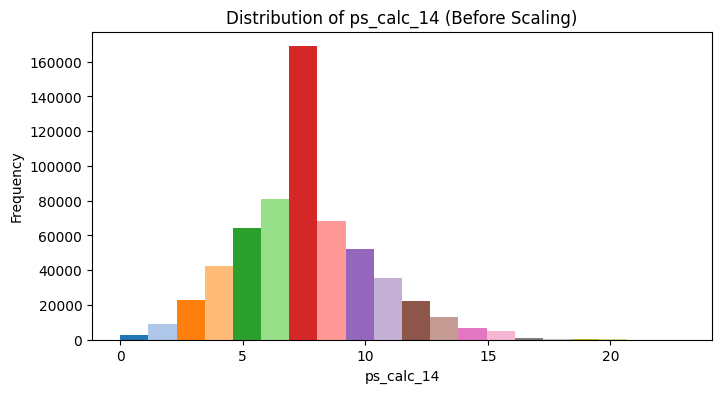

In [15]:
plot_distributions(num_cols,20)

In [16]:
num_cols.nunique()

,0
ps_ind_01,8
ps_ind_03,12
ps_ind_14,5
ps_ind_15,14
ps_reg_01,10
ps_reg_02,19
ps_reg_03,5013
ps_car_11,5
ps_car_12,184
ps_car_13,70482


Binary cols are probably related to past insurance happenings

Distribution for some of the remaining features are starting to resemble a skewed normal distribution. Also some are identically distributed.
I should use distinct feature engineering for different types of variables.
While there are no explicit meaning attached, there are distinct feature categories that I should further explore.

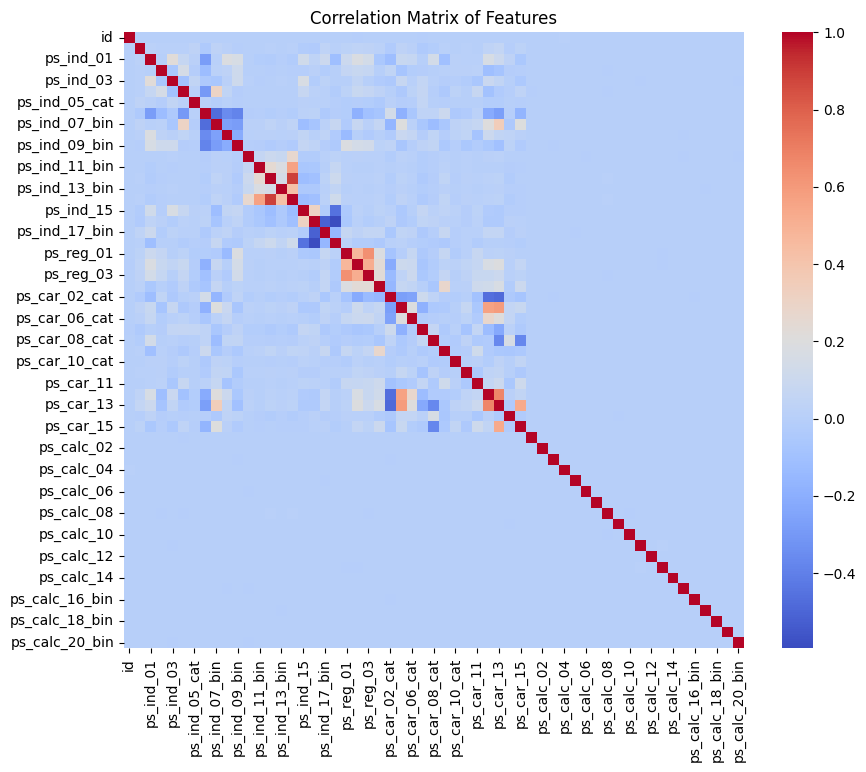

In [17]:
#check if there are any significant correlations

plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(), cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

They can be later reviewed, some rather strong correlation shows

In [18]:
# Class count
count_class_0, count_class_1 = train_data.target.value_counts()

# Divide by class
df_class_0 = train_data[train_data['target'] == 0]
df_class_1 = train_data[train_data['target'] == 1]


In [19]:
len(df_class_1)

21694

Missing data handling

In [20]:

num_col_names = num_cols.columns.tolist()
cat_col_names = cat_cols.columns.tolist()
bin_col_names = bin_cols.columns.tolist()

In [21]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

# Create the imputers
cat_imputer = SimpleImputer(strategy="most_frequent")  # Mode for categorical
knn_imputer = KNNImputer(n_neighbors=5)  # KNN imputer for numerical features

# Apply imputation
train_data[cat_col_names + bin_col_names] = cat_imputer.fit_transform(train_data[cat_col_names + bin_col_names])
test_data[cat_col_names + bin_col_names] = cat_imputer.transform(test_data[cat_col_names + bin_col_names])

train_data[num_col_names] = knn_imputer.fit_transform(train_data[num_col_names])
test_data[num_col_names] = knn_imputer.transform(test_data[num_col_names])

## Preparations and model tuning/validation
First I find the optimal sampling method with a smaller dataset


In [67]:
train_data.dropna(axis=0, inplace=True)

#use only a fraction of data for analysis - stratified split to keep target proportions
train_data_small, _ = train_test_split(
    train_data,
    test_size=0.9,
    random_state=42,
    stratify=train_data['target']
)

# Reset the index if needed
train_data_small = train_data_small.reset_index(drop=True)

#model performance attribution with smaller data size
X1 = train_data_small.drop(['target','id'], axis=1)

y = train_data_small.target
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42) # using stratified train/test split to keep class imbalance consi


In [23]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score
from sklearn.compose import ColumnTransformer

In [24]:
df_class_0 = y[y == 0]
df_class_1 = y[y == 1]

len(df_class_1)

2169

In [25]:
# sampling
#resample and fit rf


#it can be better to use under/oversampling combined to minimize information loss

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import ADASYN
#categorical data usually need different handling in under/oversampling
from imblearn.over_sampling import SMOTENC


all_cat_bin_cols = cat_col_names + bin_col_names

# Convert column names to indices
cat_bin_col_indices = [X1.columns.get_loc(col) for col in all_cat_bin_cols]

smote_nc = SMOTENC(categorical_features=cat_bin_col_indices, random_state=42)
X_smnc, y_smnc = smote_nc.fit_resample(X1, y)



In [51]:
from sklearn.metrics import roc_auc_score, make_scorer

def normalized_gini(y_true, y_pred):
    """Compute normalized Gini as 2 * ROC AUC - 1."""
    auc = roc_auc_score(y_true, y_pred)
    return 2 * auc - 1


gini_scorer = make_scorer(normalized_gini, greater_is_better=True)

In [27]:
#RFC fit for testing sampling performance
def RFC_classifier(X_train, y_train, X_test, y_test, resampling_method):
  print(y_train.value_counts(), '\n')
  print('Using '+resampling_method)
  model = RandomForestClassifier(max_depth = 5, random_state=42)

  model.fit(X_train, y_train)

  y_pred = model.predict_proba(X_test)[:,1]
  tr_preds = model.predict_proba(X_train)


  auc = roc_auc_score(y_test, y_pred)

  gini_n = normalized_gini(y_test, y_pred)
  print(f"Gini Coefficient: {gini_n:.4f}")
  y_pred_class = (y_pred >= 0.5).astype(int)
  print('Percentage of negative predictions: ', np.sum(y_pred_class == 0) / len(y_pred_class))

  #to visualize feature importance later
  feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
  })


  train_pred = model.predict_proba(X_train)[:, 1]
  test_pred = model.predict_proba(X_test)[:, 1]

  train_auc = roc_auc_score(y_train, train_pred)
  test_auc = roc_auc_score(y_test, test_pred)

  print(f"Train AUC: {train_auc:.4f}, Test AUC: {test_auc:.4f}")

  return gini_n, feature_importance_df

In [28]:
#under/oversampling
smt = SMOTE(sampling_strategy='auto', random_state=42)

smote_k_neighbors = [5,7,9,11,13]

for i in smote_k_neighbors:
  print('K neighbors: ', i)
  sm = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors = i)
  X_sm, y_sm = sm.fit_resample(X_train,y_train)
  gini_sm, feature_importance = RFC_classifier(X_sm,y_sm,X_test,y_test,'SMOTE oversampling')


K neighbors:  5
target
0    45884
1    45884
Name: count, dtype: int64 

Using SMOTE oversampling
Gini Coefficient: 0.1733
Percentage of negative predictions:  0.8809743805123897
Train AUC: 0.9512, Test AUC: 0.5866
K neighbors:  7
target
0    45884
1    45884
Name: count, dtype: int64 

Using SMOTE oversampling
Gini Coefficient: 0.1808
Percentage of negative predictions:  0.8814783704325914
Train AUC: 0.9506, Test AUC: 0.5904
K neighbors:  9
target
0    45884
1    45884
Name: count, dtype: int64 

Using SMOTE oversampling
Gini Coefficient: 0.1774
Percentage of negative predictions:  0.8873582528349433
Train AUC: 0.9519, Test AUC: 0.5887
K neighbors:  11
target
0    45884
1    45884
Name: count, dtype: int64 

Using SMOTE oversampling
Gini Coefficient: 0.1891
Percentage of negative predictions:  0.8860142797144057
Train AUC: 0.9513, Test AUC: 0.5946
K neighbors:  13
target
0    45884
1    45884
Name: count, dtype: int64 

Using SMOTE oversampling
Gini Coefficient: 0.1901
Percentage of n

SMOTE with k_neighbours = 7 was the best for lowest train/test AUC difference, number of negative prediction and gini score relatively

> Idézetblokk hozzáadása

> Idézetblokk hozzáadása





In [44]:
sm = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors = 7)
X_sm, y_sm = sm.fit_resample(X_train,y_train)

In [30]:
#other methods with k = 7
#under/oversampling
smt = SMOTETomek(sampling_strategy='auto', random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train,y_train)


#cluster centroids undersampling
cc = ClusterCentroids(sampling_strategy={0: 2219}, random_state=42)
X_cc, y_cc = cc.fit_resample(X_train, y_train)

#similar to SMOTE but slightly different
ada = ADASYN(sampling_strategy = 'minority', random_state=42, n_neighbors = 9)
X_ada, y_ada = ada.fit_resample(X_train, y_train)

gini_smt = RFC_classifier(X_train_smt,y_train_smt,X_test,y_test,'SMOTE Tomek under/oversampling')

gini_cc = RFC_classifier(X_cc,y_cc,X_test,y_test,'Cluster Centroids undersampling')

gini_ada = RFC_classifier(X_ada,y_ada,X_test,y_test,'ADASYN oversampling')

gini_smnc = RFC_classifier(X_smnc,y_smnc,X_test,y_test,'SMOTENC oversampling')


target
0    45884
1    45884
Name: count, dtype: int64 

Using SMOTE Tomek under/oversampling
Gini Coefficient: 0.1733
Percentage of negative predictions:  0.8809743805123897
Train AUC: 0.9512, Test AUC: 0.5866
target
0    2219
1    1732
Name: count, dtype: int64 

Using Cluster Centroids undersampling
Gini Coefficient: -0.0806
Percentage of negative predictions:  0.0
Train AUC: 1.0000, Test AUC: 0.4597
target
1    46525
0    45884
Name: count, dtype: int64 

Using ADASYN oversampling
Gini Coefficient: 0.1718
Percentage of negative predictions:  0.8789584208315834
Train AUC: 0.9504, Test AUC: 0.5859
target
0    57352
1    57352
Name: count, dtype: int64 

Using SMOTENC oversampling
Gini Coefficient: 0.1499
Percentage of negative predictions:  0.8488030239395212
Train AUC: 0.9477, Test AUC: 0.5749


SMOTE seems to be the superior sampling method here

In [52]:
#optimize rfc

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],   # Number of trees
    'max_depth': [3,5],  # Tree depth
    'min_samples_split': [2, 3],  # Min samples required to split
    'min_samples_leaf': [1, 2],   # Min samples in a leaf
}

# Perform Grid Search CV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring=gini_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_sm, y_sm)

# Get the best model
best_rf = grid_search.best_estimator_

optimized_rf_model = grid_search.best_estimator_

# Predict on test set
rf_pred = best_rf.predict_proba(X_test)[:, 1]

# Evaluate performance
auc_score = roc_auc_score(y_test, rf_pred)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"AUC Score: {auc_score}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
AUC Score: 0.5916950080574421


In [53]:

train_pred = optimized_rf_model.predict_proba(X_sm)[:, 1]
train_auc = roc_auc_score(y_sm, train_pred)
test_auc = roc_auc_score(y_test, rf_pred)

print(f"Train AUC: {train_auc:.4f}, Test AUC: {test_auc:.4f}")

rf_score = normalized_gini(y_test, rf_pred)
print(rf_score)

RFC_classifier(X_sm,y_sm,X_test,y_test,'Optimized RF')

Train AUC: 0.9510, Test AUC: 0.5917
0.18339001611488426
target
0    45884
1    45884
Name: count, dtype: int64 

Using Optimized RF
Gini Coefficient: 0.1808
Percentage of negative predictions:  0.8814783704325914
Train AUC: 0.9506, Test AUC: 0.5904


(0.18078760997670162,
            Feature  Importance
 0        ps_ind_01    0.045975
 1    ps_ind_02_cat    0.000129
 2        ps_ind_03    0.000674
 3    ps_ind_04_cat    0.019160
 4    ps_ind_05_cat    0.000513
 5    ps_ind_06_bin    0.099531
 6    ps_ind_07_bin    0.008073
 7    ps_ind_08_bin    0.028913
 8    ps_ind_09_bin    0.082591
 9    ps_ind_10_bin    0.000000
 10   ps_ind_11_bin    0.000000
 11   ps_ind_12_bin    0.000002
 12   ps_ind_13_bin    0.000003
 13       ps_ind_14    0.000096
 14       ps_ind_15    0.000584
 15   ps_ind_16_bin    0.032897
 16   ps_ind_17_bin    0.008902
 17   ps_ind_18_bin    0.006853
 18       ps_reg_01    0.020275
 19       ps_reg_02    0.060439
 20       ps_reg_03    0.095014
 21   ps_car_01_cat    0.000180
 22   ps_car_02_cat    0.018016
 23   ps_car_04_cat    0.000340
 24   ps_car_06_cat    0.000409
 25   ps_car_07_cat    0.012018
 26   ps_car_08_cat    0.009518
 27   ps_car_09_cat    0.010810
 28   ps_car_10_cat    0.000135
 29   ps_car_11_ca

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Gradient Boosting Classifier
param_grid = {
    'n_estimators': [ 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [1, 3],
    'min_samples_split': [1, 3],
    'min_samples_leaf': [ 1, 2]
}

# Perform Grid Search CV
grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    scoring= gini_scorer,  # Use AUC for binary classification
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_sm, y_sm)

boosting_params = grid_search.best_params_
# Best model from grid search
optimized_boosting_model = grid_search.best_estimator_

# Get probability predictions for class 1
boosting_pred = optimized_boosting_model.predict_proba(X_test)[:, 1]

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
24 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_

In [ ]:
grid_search.best_estimator_

In [55]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
# Define parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0,2],
    'max_depth': [1, 2],
    'min_child_weight': [1, 3],  # Equivalent to min_samples_leaf
    'subsample': [0.5, 0.6],  # Fraction of data used per tree
    'colsample_bytree': [0.5, 0.6],  # Fraction of features used per tree
    'gamma': [ 0.1, 0.2]
}

# Perform Grid Search CV
grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring= gini_scorer,  # Use AUC for binary classification
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_sm, y_sm)

# Best model from grid search
optimized_xgb_model = grid_search.best_estimator_

# Get probability predictions for class 1
XGB_pred = optimized_xgb_model.predict_proba(X_test)[:, 1]

print(optimized_xgb_model.get_params())

Fitting 3 folds for each of 256 candidates, totalling 768 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:20:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 2, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}


In [68]:
xgb_score = normalized_gini(y_test, XGB_pred)
boosting_score = normalized_gini(y_test, boosting_pred)
rf_score = normalized_gini(y_test, rf_pred)

print(xgb_score)
print(boosting_score)
print(rf_score)


0.13754241231595388
0.14042696860590675
0.18339001611488426


Fit optimized model to entire dataset

Fit models to whole training dataset to see

In [69]:
X_train_full = train_data.drop(['id','target'], axis = 1)
X_test_full = test_data.drop(['id'], axis = 1)
y_train_full = train_data['target']

X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify =y_train_full) # using stratified train/test split to keep class imbalance consi
# Using SMOTE as final
#oversampling

sm = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors = 7)
X_sm, y_sm = sm.fit_resample(X_train,y_train)


In [60]:

rf_model_full = optimized_rf_model.fit(X_sm, y_sm)

rf_pred_full = rf_model_full.predict_proba(X_test)[:, 1]


rf_score_full = normalized_gini(y_test, rf_pred_full)

print(rf_score_full)

0.11511582174808321


In [70]:
#for final test data

rf_pred_final = rf_model_full.predict_proba(X_test_full)[:, 1]
test_ids = test_data['id']
# Create the submission DataFrame
submission = pd.DataFrame({"id": test_ids, "target": rf_pred_final})

# Save the submission to a CSV file
submission.to_csv("submission.csv", index=False)

In [62]:
rf_pred_final

array([0.36870935, 0.23590478, 0.5140602 , ..., 0.34978937, 0.48160049,
       0.32100894])